## 1. 사용할 패키지 불러오기

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pwd

/content


In [2]:
%cd '/content/drive/MyDrive/kmong/car_number'

/content/drive/MyDrive/kmong/car_number


In [3]:
import sys
sys.path.append('/content/gdrive/MyDrive/kmong/car_number/data_gen')

In [4]:
import pandas as pd
import cv2
import os
from sklearn.model_selection import train_test_split
from torch.optim import Adam
from torch.nn import L1Loss
import json
from data_gen.data_gen import DatasetGenerator
import torch
import torchvision.models as models
import torch.nn as nn
import numpy as np
from tqdm import tqdm

## 2. 데이터 불러오기

### (0) 압축파일 풀기

In [ ]:
%cd /content
!unzip -qq "/content/drive/MyDrive/크몽/221113 번호판인식.zip"

/content
replace data_gen/__init__.py? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

### (1) 이미지 및 Json 파일 리스트 불러오기

In [5]:
train_img_dir = "/content/drive/MyDrive/kmong/car_number/dataset/train/img"
train_json_dir = "/content/drive/MyDrive/kmong/car_number/dataset/train/json"
test_img_dir = "/content/drive/MyDrive/kmong/car_number/dataset/test/img"
test_json_dir = "/content/drive/MyDrive/kmong/car_number/dataset/test/json"

In [6]:
train_img_list = os.listdir(train_img_dir)
train_img_list = sorted(train_img_list)
train_img_list = [os.path.join(train_img_dir, img) for img in train_img_list]
train_json_list = os.listdir(train_json_dir)
train_json_list = sorted(train_json_list)
train_json_list = [os.path.join(train_json_dir, js) for js in train_json_list]

test_img_list = os.listdir(test_img_dir)
test_img_list = sorted(test_img_list)
test_img_list = [os.path.join(test_img_dir, img) for img in test_img_list]
test_json_list = os.listdir(test_json_dir)
test_json_list = sorted(test_json_list)
test_json_list = [os.path.join(test_json_dir, js) for js in test_json_list]

print("Train Image 개수: {}".format(len(train_img_list)))
print("Test Image 개수: {}".format(len(test_img_list)))

Train Image 개수: 1006
Test Image 개수: 77


## 3. 모델링

### (1) Dataloader 생성

In [7]:
train_dataset = DatasetGenerator(train_img_list, train_json_list, batch_size = 16, phase = 'train')
train_dataloader = train_dataset.dataloader()
test_dataset = DatasetGenerator(test_img_list, test_json_list, batch_size = 1, phase = 'test',)
test_dataloader = test_dataset.dataloader()                 

### (2) Model 생성

In [8]:
model_name = 'resnet18'

In [9]:
# build model
vision_model = models.resnet18(pretrained=True)
num_ftrs = vision_model.fc.in_features
vision_model.fc = nn.Linear(num_ftrs, 8)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

### (3) 학습 파라미터 지정

In [10]:
epoch = 100
learning_rate = 0.001
weight_decay = 0.0001
result_dir = './result/'
os.makedirs(result_dir, exist_ok = True)

### (4) Loss, Optimizer 생성

In [11]:
# get loss function from LossFactory
loss_fn = L1Loss()

# get optimizer from OptimizerFactory
optimizer = Adam(params = vision_model.parameters(),
                lr=learning_rate,
                weight_decay = weight_decay)

### (5) 학습

In [12]:
print("{} start training!".format(model_name))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vision_model.to(device)
min_valid_loss = np.inf

# training
for e in range(epoch):
    train_loss = 0.0
    vision_model.train()     # Optional when not using Model Specific layer
    for data in tqdm(train_dataloader['train']):
        if torch.cuda.is_available():
            images, labels = data['image'].float().to(device), data['target'].float().to(device)
        
        optimizer.zero_grad()
        target = vision_model(images)
        loss = loss_fn(target,labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() / len(images)
            
    valid_loss = 0.0
    vision_model.eval()     # Optional when not using Model Specific layer
    for data in tqdm(test_dataloader['test']):
        if torch.cuda.is_available():
            data, labels = data['image'].float().to(device), data['target'].float().to(device)
        
        target = vision_model(data)
        loss = loss_fn(target,labels)
        valid_loss = loss.item() * len(data)

    print("Epoch: {}, Training Loss: {}, Test Loss: {}".format(e+1, train_loss / len(train_dataloader['train']), valid_loss))   
    if min_valid_loss > valid_loss:
        print(f'Validation Loss Decreased({min_valid_loss:.6f}--->{valid_loss:.6f}) \t Saving The Model')
        min_valid_loss = valid_loss
        # Saving State Dict
        torch.save(vision_model.state_dict(), result_dir + 'Best_model.pth')    

resnet18 start training!


100%|██████████| 77/77 [01:37<00:00,  1.26s/it]


Epoch: 1, Training Loss: 9.19306781773124, Test Loss: 145.7801513671875
Validation Loss Decreased(inf--->145.780151) 	 Saving The Model


100%|██████████| 77/77 [00:02<00:00, 30.18it/s]


Epoch: 2, Training Loss: 6.762523420813943, Test Loss: 120.13349914550781
Validation Loss Decreased(145.780151--->120.133499) 	 Saving The Model


100%|██████████| 77/77 [00:02<00:00, 29.79it/s]


Epoch: 3, Training Loss: 5.089969564727645, Test Loss: 78.393798828125
Validation Loss Decreased(120.133499--->78.393799) 	 Saving The Model


100%|██████████| 77/77 [00:02<00:00, 31.51it/s]


Epoch: 4, Training Loss: 3.746093920839617, Test Loss: 52.56843566894531
Validation Loss Decreased(78.393799--->52.568436) 	 Saving The Model


100%|██████████| 77/77 [00:02<00:00, 30.71it/s]


Epoch: 5, Training Loss: 2.28366604954207, Test Loss: 34.853851318359375
Validation Loss Decreased(52.568436--->34.853851) 	 Saving The Model


100%|██████████| 77/77 [00:02<00:00, 30.73it/s]


Epoch: 6, Training Loss: 1.6179024145987029, Test Loss: 37.226619720458984


100%|██████████| 77/77 [00:02<00:00, 31.87it/s]


Epoch: 7, Training Loss: 1.526793317594766, Test Loss: 33.21992492675781
Validation Loss Decreased(34.853851--->33.219925) 	 Saving The Model


100%|██████████| 77/77 [00:02<00:00, 31.58it/s]


Epoch: 8, Training Loss: 1.3586160673035517, Test Loss: 36.39372253417969


100%|██████████| 77/77 [00:02<00:00, 31.25it/s]


Epoch: 9, Training Loss: 1.210774839194724, Test Loss: 24.72186279296875
Validation Loss Decreased(33.219925--->24.721863) 	 Saving The Model


100%|██████████| 77/77 [00:02<00:00, 31.79it/s]


Epoch: 10, Training Loss: 1.1200569660620354, Test Loss: 23.43450927734375
Validation Loss Decreased(24.721863--->23.434509) 	 Saving The Model


100%|██████████| 77/77 [00:02<00:00, 30.86it/s]


Epoch: 11, Training Loss: 1.037637681917809, Test Loss: 16.04869842529297
Validation Loss Decreased(23.434509--->16.048698) 	 Saving The Model


100%|██████████| 77/77 [00:02<00:00, 30.79it/s]


Epoch: 12, Training Loss: 1.0181039840726356, Test Loss: 15.62873649597168
Validation Loss Decreased(16.048698--->15.628736) 	 Saving The Model


100%|██████████| 77/77 [00:02<00:00, 30.97it/s]


Epoch: 13, Training Loss: 0.9815056268590379, Test Loss: 14.119543075561523
Validation Loss Decreased(15.628736--->14.119543) 	 Saving The Model


100%|██████████| 77/77 [00:02<00:00, 30.76it/s]


Epoch: 14, Training Loss: 0.9489537081480567, Test Loss: 14.854181289672852


100%|██████████| 77/77 [00:02<00:00, 31.79it/s]


Epoch: 15, Training Loss: 0.9189789971661946, Test Loss: 14.5601806640625


100%|██████████| 77/77 [00:02<00:00, 31.35it/s]


Epoch: 16, Training Loss: 0.8926351948930562, Test Loss: 14.894600868225098


100%|██████████| 77/77 [00:02<00:00, 31.70it/s]


Epoch: 17, Training Loss: 0.8770762061586186, Test Loss: 12.244571685791016
Validation Loss Decreased(14.119543--->12.244572) 	 Saving The Model


100%|██████████| 77/77 [00:02<00:00, 30.58it/s]


Epoch: 18, Training Loss: 0.8844362471649706, Test Loss: 13.261979103088379


100%|██████████| 77/77 [00:02<00:00, 30.48it/s]


Epoch: 19, Training Loss: 0.8825379056589944, Test Loss: 12.685222625732422


100%|██████████| 77/77 [00:02<00:00, 31.01it/s]


Epoch: 20, Training Loss: 0.8361459931954235, Test Loss: 13.927007675170898


100%|██████████| 77/77 [00:02<00:00, 31.33it/s]


Epoch: 21, Training Loss: 0.8552674863343878, Test Loss: 14.428727149963379


100%|██████████| 77/77 [00:02<00:00, 31.16it/s]


Epoch: 22, Training Loss: 0.8331487091625629, Test Loss: 13.823039054870605


100%|██████████| 77/77 [00:02<00:00, 30.72it/s]


Epoch: 23, Training Loss: 0.8139886753359079, Test Loss: 13.33450698852539


100%|██████████| 77/77 [00:02<00:00, 30.98it/s]


Epoch: 24, Training Loss: 0.8096660447904583, Test Loss: 17.35462188720703


100%|██████████| 77/77 [00:02<00:00, 32.05it/s]


Epoch: 25, Training Loss: 0.8190955898794187, Test Loss: 19.66881561279297


100%|██████████| 77/77 [00:02<00:00, 30.87it/s]


Epoch: 26, Training Loss: 0.8419488381906972, Test Loss: 14.141468048095703


100%|██████████| 77/77 [00:02<00:00, 31.17it/s]


Epoch: 27, Training Loss: 0.7921231009927737, Test Loss: 13.76407527923584


100%|██████████| 77/77 [00:02<00:00, 31.27it/s]


Epoch: 28, Training Loss: 0.7710495788494205, Test Loss: 14.014220237731934


100%|██████████| 77/77 [00:02<00:00, 31.04it/s]


Epoch: 29, Training Loss: 0.7731185312511699, Test Loss: 12.526551246643066


100%|██████████| 77/77 [00:02<00:00, 32.12it/s]


Epoch: 30, Training Loss: 0.7857015473502023, Test Loss: 12.485725402832031


100%|██████████| 77/77 [00:02<00:00, 31.20it/s]


Epoch: 31, Training Loss: 0.7367646932737086, Test Loss: 14.364555358886719


100%|██████████| 77/77 [00:02<00:00, 30.96it/s]


Epoch: 32, Training Loss: 0.7549929860092345, Test Loss: 13.630922317504883


100%|██████████| 77/77 [00:02<00:00, 30.60it/s]


Epoch: 33, Training Loss: 0.7299745330194227, Test Loss: 13.474369049072266


100%|██████████| 77/77 [00:02<00:00, 31.22it/s]


Epoch: 34, Training Loss: 0.7454173657831962, Test Loss: 14.37899398803711


100%|██████████| 77/77 [00:02<00:00, 31.73it/s]


Epoch: 35, Training Loss: 0.7148488389661792, Test Loss: 15.591033935546875


100%|██████████| 77/77 [00:02<00:00, 31.17it/s]


Epoch: 36, Training Loss: 0.7157221835216427, Test Loss: 7.006804943084717
Validation Loss Decreased(12.244572--->7.006805) 	 Saving The Model


100%|██████████| 77/77 [00:02<00:00, 31.16it/s]


Epoch: 37, Training Loss: 0.7207000466431079, Test Loss: 5.77769660949707
Validation Loss Decreased(7.006805--->5.777697) 	 Saving The Model


100%|██████████| 77/77 [00:02<00:00, 31.42it/s]


Epoch: 38, Training Loss: 0.6772626903997797, Test Loss: 11.088068008422852


100%|██████████| 77/77 [00:02<00:00, 31.51it/s]


Epoch: 39, Training Loss: 0.6631760427943703, Test Loss: 9.361260414123535


100%|██████████| 77/77 [00:02<00:00, 30.32it/s]


Epoch: 40, Training Loss: 0.6739180438778027, Test Loss: 8.764626502990723


100%|██████████| 77/77 [00:02<00:00, 31.69it/s]


Epoch: 41, Training Loss: 0.6583329954114902, Test Loss: 7.759994029998779


100%|██████████| 77/77 [00:02<00:00, 30.43it/s]


Epoch: 42, Training Loss: 0.64915553039434, Test Loss: 6.758753299713135


100%|██████████| 77/77 [00:02<00:00, 31.24it/s]


Epoch: 43, Training Loss: 0.6606082821649218, Test Loss: 8.663747787475586


100%|██████████| 77/77 [00:02<00:00, 31.17it/s]


Epoch: 44, Training Loss: 0.6686335772343504, Test Loss: 9.351633071899414


100%|██████████| 77/77 [00:02<00:00, 30.61it/s]


Epoch: 45, Training Loss: 0.6455141043717088, Test Loss: 14.803155899047852


100%|██████████| 77/77 [00:02<00:00, 31.14it/s]


Epoch: 46, Training Loss: 0.6162000895560192, Test Loss: 5.204229831695557
Validation Loss Decreased(5.777697--->5.204230) 	 Saving The Model


100%|██████████| 77/77 [00:02<00:00, 30.95it/s]


Epoch: 47, Training Loss: 0.6030347856129108, Test Loss: 8.511978149414062


100%|██████████| 77/77 [00:02<00:00, 31.70it/s]


Epoch: 48, Training Loss: 0.6092339418575066, Test Loss: 7.943575859069824


100%|██████████| 77/77 [00:02<00:00, 31.89it/s]


Epoch: 49, Training Loss: 0.5945393023442249, Test Loss: 5.883597373962402


100%|██████████| 77/77 [00:02<00:00, 31.64it/s]


Epoch: 50, Training Loss: 0.5981924932221977, Test Loss: 8.362409591674805


100%|██████████| 77/77 [00:02<00:00, 31.61it/s]


Epoch: 51, Training Loss: 0.5795397934189188, Test Loss: 7.737244606018066


100%|██████████| 77/77 [00:02<00:00, 31.48it/s]


Epoch: 52, Training Loss: 0.5781994975613358, Test Loss: 5.114879131317139
Validation Loss Decreased(5.204230--->5.114879) 	 Saving The Model


100%|██████████| 77/77 [00:02<00:00, 31.06it/s]


Epoch: 53, Training Loss: 0.6179887119874933, Test Loss: 7.515742301940918


100%|██████████| 77/77 [00:02<00:00, 31.61it/s]


Epoch: 54, Training Loss: 0.5546743494718253, Test Loss: 8.08336353302002


100%|██████████| 77/77 [00:02<00:00, 31.59it/s]


Epoch: 55, Training Loss: 0.5239162661996829, Test Loss: 5.357152462005615


100%|██████████| 77/77 [00:02<00:00, 31.83it/s]


Epoch: 56, Training Loss: 0.5318192925109885, Test Loss: 5.0642194747924805
Validation Loss Decreased(5.114879--->5.064219) 	 Saving The Model


100%|██████████| 77/77 [00:02<00:00, 31.66it/s]


Epoch: 57, Training Loss: 0.5155140710255456, Test Loss: 8.67618179321289


100%|██████████| 77/77 [00:02<00:00, 30.07it/s]


Epoch: 58, Training Loss: 0.5343952488804621, Test Loss: 9.831327438354492


100%|██████████| 77/77 [00:02<00:00, 30.20it/s]


Epoch: 59, Training Loss: 0.48650887483507055, Test Loss: 9.31247615814209


100%|██████████| 77/77 [00:02<00:00, 30.70it/s]


Epoch: 60, Training Loss: 0.4889771105413264, Test Loss: 6.744914531707764


100%|██████████| 77/77 [00:02<00:00, 30.61it/s]


Epoch: 61, Training Loss: 0.4611768659685745, Test Loss: 6.981003761291504


100%|██████████| 77/77 [00:02<00:00, 30.56it/s]


Epoch: 62, Training Loss: 0.48362776579635214, Test Loss: 14.692757606506348


100%|██████████| 77/77 [00:02<00:00, 30.71it/s]


Epoch: 63, Training Loss: 0.4373865643190959, Test Loss: 6.2884955406188965


100%|██████████| 77/77 [00:02<00:00, 30.66it/s]


Epoch: 64, Training Loss: 0.43337213300388144, Test Loss: 6.542710304260254


100%|██████████| 77/77 [00:02<00:00, 30.48it/s]


Epoch: 65, Training Loss: 0.41694923086501573, Test Loss: 7.7844648361206055


100%|██████████| 77/77 [00:02<00:00, 30.90it/s]


Epoch: 66, Training Loss: 0.44742052993671694, Test Loss: 6.220120429992676


100%|██████████| 77/77 [00:02<00:00, 31.13it/s]


Epoch: 67, Training Loss: 0.4191883989607666, Test Loss: 5.029228210449219
Validation Loss Decreased(5.064219--->5.029228) 	 Saving The Model


100%|██████████| 77/77 [00:02<00:00, 30.66it/s]


Epoch: 68, Training Loss: 0.3882122916969853, Test Loss: 6.296821117401123


100%|██████████| 77/77 [00:02<00:00, 30.54it/s]


Epoch: 69, Training Loss: 0.4224921961625417, Test Loss: 6.091256618499756


100%|██████████| 77/77 [00:02<00:00, 30.89it/s]


Epoch: 70, Training Loss: 0.3824853811945234, Test Loss: 6.359959125518799


100%|██████████| 77/77 [00:02<00:00, 30.60it/s]


Epoch: 71, Training Loss: 0.3463480481349962, Test Loss: 6.432279586791992


100%|██████████| 77/77 [00:02<00:00, 31.08it/s]


Epoch: 72, Training Loss: 0.3775646042188549, Test Loss: 4.030041217803955
Validation Loss Decreased(5.029228--->4.030041) 	 Saving The Model


100%|██████████| 77/77 [00:02<00:00, 30.52it/s]


Epoch: 73, Training Loss: 0.36917729020253875, Test Loss: 5.762569904327393


100%|██████████| 77/77 [00:02<00:00, 30.62it/s]


Epoch: 74, Training Loss: 0.3659004084174595, Test Loss: 5.114446640014648


100%|██████████| 77/77 [00:02<00:00, 30.49it/s]


Epoch: 75, Training Loss: 0.33646238650999916, Test Loss: 5.060349464416504


100%|██████████| 77/77 [00:02<00:00, 30.87it/s]


Epoch: 76, Training Loss: 0.3459071181967956, Test Loss: 5.719144821166992


100%|██████████| 77/77 [00:02<00:00, 30.35it/s]


Epoch: 77, Training Loss: 0.33978103611474675, Test Loss: 4.818815231323242


100%|██████████| 77/77 [00:02<00:00, 32.23it/s]


Epoch: 78, Training Loss: 0.34097766044999467, Test Loss: 5.544243812561035


100%|██████████| 77/77 [00:02<00:00, 31.58it/s]


Epoch: 79, Training Loss: 0.346065182027633, Test Loss: 3.8289504051208496
Validation Loss Decreased(4.030041--->3.828950) 	 Saving The Model


100%|██████████| 77/77 [00:02<00:00, 31.43it/s]


Epoch: 80, Training Loss: 0.32762547874666936, Test Loss: 5.397416591644287


100%|██████████| 77/77 [00:02<00:00, 31.30it/s]


Epoch: 81, Training Loss: 0.31289584809690374, Test Loss: 4.465985298156738


100%|██████████| 77/77 [00:02<00:00, 31.98it/s]


Epoch: 82, Training Loss: 0.31575474274807236, Test Loss: 6.023870468139648


100%|██████████| 77/77 [00:02<00:00, 30.43it/s]


Epoch: 83, Training Loss: 0.2983445526520952, Test Loss: 5.182785511016846


100%|██████████| 77/77 [00:02<00:00, 31.71it/s]


Epoch: 84, Training Loss: 0.2967203841660839, Test Loss: 6.001689434051514


100%|██████████| 77/77 [00:02<00:00, 31.66it/s]


Epoch: 85, Training Loss: 0.2908449493635809, Test Loss: 4.145802974700928


100%|██████████| 77/77 [00:02<00:00, 31.76it/s]


Epoch: 86, Training Loss: 0.30560608400779515, Test Loss: 5.378609657287598


100%|██████████| 77/77 [00:02<00:00, 31.51it/s]


Epoch: 87, Training Loss: 0.3085818835396886, Test Loss: 5.148292541503906


100%|██████████| 77/77 [00:02<00:00, 32.38it/s]


Epoch: 88, Training Loss: 0.29774157854975486, Test Loss: 4.629142761230469


100%|██████████| 77/77 [00:02<00:00, 31.47it/s]


Epoch: 89, Training Loss: 0.32390407379927816, Test Loss: 5.371664047241211


100%|██████████| 77/77 [00:02<00:00, 32.11it/s]


Epoch: 90, Training Loss: 0.2914856934831256, Test Loss: 5.058239936828613


100%|██████████| 77/77 [00:02<00:00, 31.88it/s]


Epoch: 91, Training Loss: 0.29105445671649205, Test Loss: 4.921082496643066


100%|██████████| 77/77 [00:02<00:00, 31.56it/s]


Epoch: 92, Training Loss: 0.27612836506901955, Test Loss: 5.30970573425293


100%|██████████| 77/77 [00:02<00:00, 31.66it/s]


Epoch: 93, Training Loss: 0.29905821521536297, Test Loss: 5.007458209991455


100%|██████████| 77/77 [00:02<00:00, 30.82it/s]


Epoch: 94, Training Loss: 0.2888699907496943, Test Loss: 6.668286323547363


100%|██████████| 77/77 [00:02<00:00, 30.99it/s]


Epoch: 95, Training Loss: 0.28391154475358066, Test Loss: 5.334872722625732


100%|██████████| 77/77 [00:02<00:00, 31.20it/s]


Epoch: 96, Training Loss: 0.26506161378895077, Test Loss: 4.782890319824219


100%|██████████| 77/77 [00:02<00:00, 31.03it/s]


Epoch: 97, Training Loss: 0.2735535895743338, Test Loss: 6.529688835144043


100%|██████████| 77/77 [00:02<00:00, 32.38it/s]


Epoch: 98, Training Loss: 0.26682481470427005, Test Loss: 6.416086673736572


100%|██████████| 77/77 [00:02<00:00, 31.90it/s]


Epoch: 99, Training Loss: 0.26160303592817047, Test Loss: 5.865675926208496


100%|██████████| 77/77 [00:02<00:00, 31.04it/s]

Epoch: 100, Training Loss: 0.28424917114159415, Test Loss: 4.943093299865723


### (6) Load Best Model

In [14]:
vision_model.load_state_dict(torch.load('result/Best_model.pth'))

<All keys matched successfully>

### (7) 성능 평가

In [ ]:
import matplotlib.pyplot as plt
def plot_prediction(image, target):
    plt.plot([target[0], target[2]], [target[1], target[3]], color="white", linewidth=3)
    plt.plot([target[2], target[6]], [target[3], target[7]], color="white", linewidth=3)
    plt.plot([target[6], target[4]], [target[7], target[5]], color="white", linewidth=3)
    plt.plot([target[4], target[0]], [target[5], target[1]], color="white", linewidth=3)

    plt.imshow(image[0, :, :])
    plt.show()

#### - 정답

Ground Truth


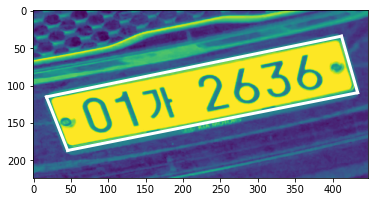

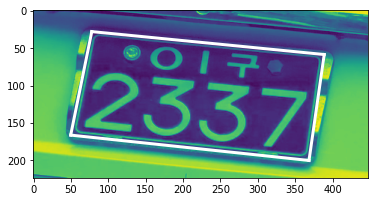

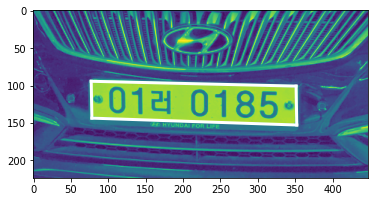

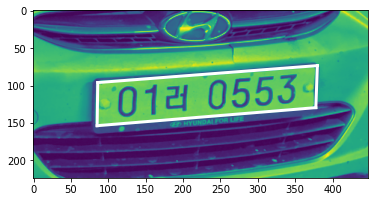

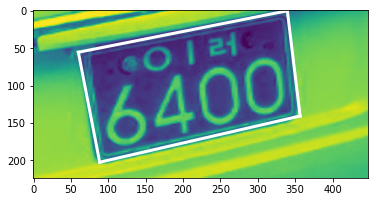

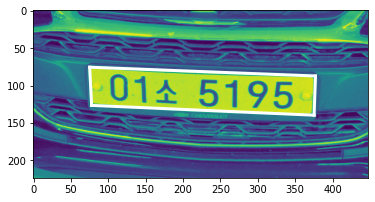

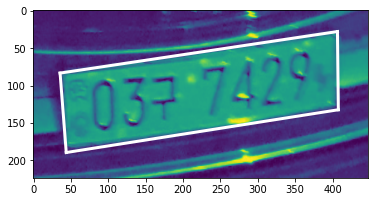

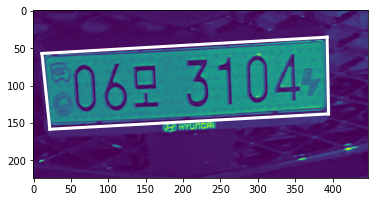

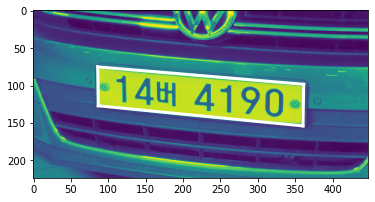

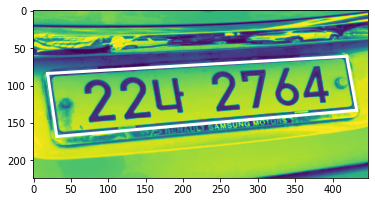

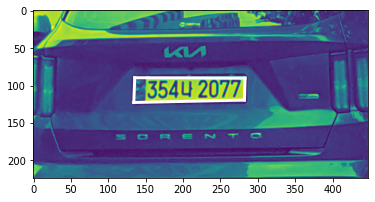

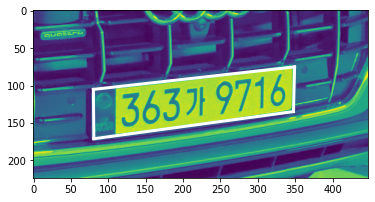

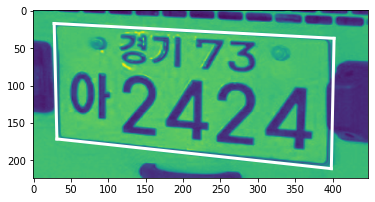

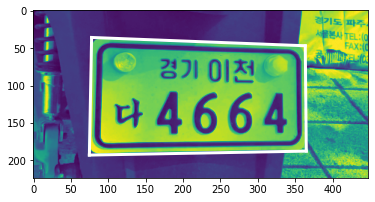

In [ ]:
print('Ground Truth')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
predictions = []
vision_model.to(device)

with torch.no_grad():  
    for data in test_dataloader['test']:
        images, labels = data['image'].float().to(device), data['target'].float().to(device)
        images = images.to(device)  
        labels = labels.to(device)  
        vision_model.eval()  
        yhat = vision_model(images)  
        pred = yhat.cpu().numpy()
        labels = labels.cpu().numpy()
        images = images.cpu().numpy()
        plot_prediction(images[0, :, :, :], labels[0])

#### - 예측

Prediction


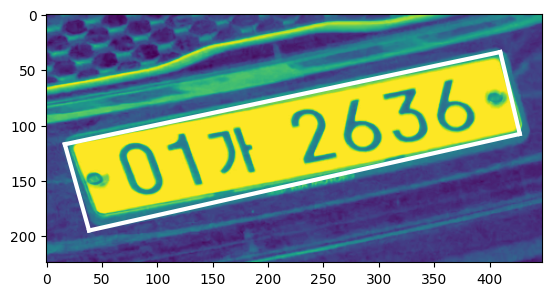

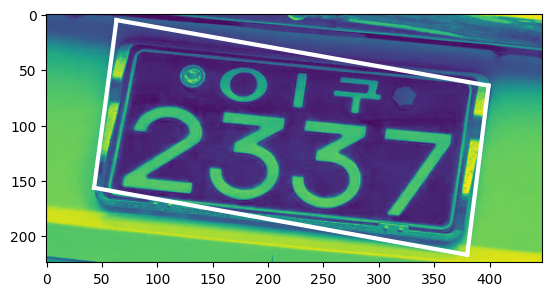

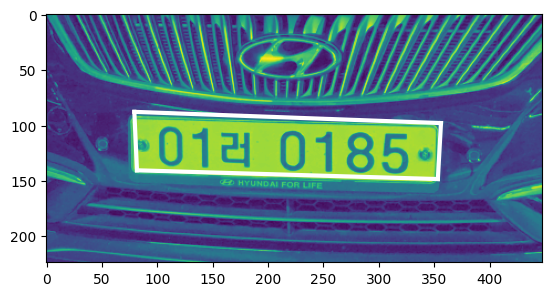

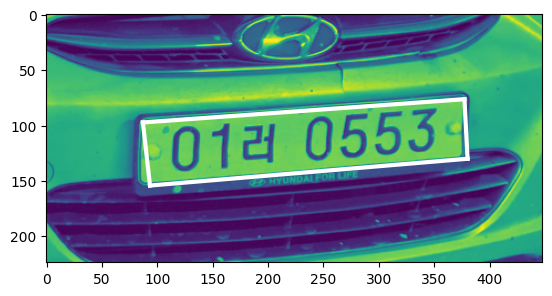

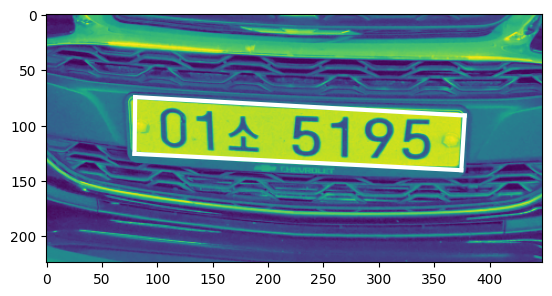

In [ ]:
print('Prediction')
predictions = []
vision_model.to(device)

with torch.no_grad():  
    for data in test_dataloader['test']:
        images, labels = data['image'].float().to(device), data['target'].float().to(device)
        images = images.to(device)  
        labels = labels.to(device)  
        vision_model.eval()  
        yhat = vision_model(images)  
        pred = yhat.cpu().numpy()
        labels = labels.cpu().numpy()
        images = images.cpu().numpy()
        plot_prediction(images[0, :, :, :], pred[0])

#### - IOU 계산

In [ ]:
def iou_calculate(labels, pred):
  img1 = np.zeros((224, 448, 3))
  points = np.array([[round(labels[0][0]), round(labels[0][1])], [round(labels[0][2]), round(labels[0][3])], [round(labels[0][6]), round(labels[0][7])], [round(labels[0][4]), round(labels[0][5])]]).reshape(1, -1, 2)
  cv2.fillPoly(img1, points, color=(0, 1, 0))

  img2 = np.zeros((224, 448, 3))
  points = np.array([[round(pred[0][0]), round(pred[0][1])], [round(pred[0][2]), round(pred[0][3])], [round(pred[0][6]), round(pred[0][7])], [round(pred[0][4]), round(pred[0][5])]]).reshape(1, -1, 2)
  cv2.fillPoly(img2, points, color=(0, 1, 0))

  iou = np.sum(img1 + img2 == 2) / np.sum(img1)
  return iou

In [ ]:
print('Calculation IOU')
predictions = []
iou_list = []
vision_model.to(device)

with torch.no_grad():  
    for data in test_dataloader['test']:
        images, labels = data['image'].float().to(device), data['target'].float().to(device)
        images = images.to(device)  
        labels = labels.to(device)  
        vision_model.eval()  
        yhat = vision_model(images)  
        pred = yhat.cpu().numpy()
        labels = labels.cpu().numpy()
        iou_list.append(iou_calculate(labels, pred))

print("Test IOU: {}".format(np.mean(iou_list)))

Calculation IOU
Test IOU: 0.9534223042268952
